In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import random
import math
import pdb

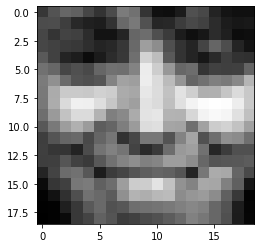

In [2]:

npzfile = np.load('data/CBCL.npz')


trainface = npzfile['arr_0'] # 2429, 361
trainnonface = npzfile['arr_1']
testface = npzfile['arr_2']
testnonface = npzfile['arr_3']
trainface.shape


face1 = trainface[400,:].reshape((19,19)) # 2400th image 
plt.imshow(face1, cmap = 'gray')

In [3]:
# preprocess
print(trainface.shape)
print(trainnonface.shape)

(2429, 361)
(4548, 361)


![title](data/dnn.jpeg)

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

# def forward(feature, s, WI, WO, i):  
#     # input -> hidden
#     ins = np.append(feature[s[i],:],1)
#     ho = ins.dot(WI) #h = aw + w0
#     ho = sigmoid(ho) # activation func.

#     # hidden -> output
#     hs = np.append(ho,1) 
#     out = hs.dot(WO) 
#     out = sigmoid(out)
#     return out, ho, hs

def BPNNtrain(pf, nf, hn, lr, iteration): # hn = hidden nodes
    pn = pf.shape[0]# 2429, positive num
    nn = nf.shape[0]# 4548, negative num
    fn = pf.shape[1]# 361, feature num
    num = pn + nn # data size
    
    feature = np.append(pf,nf,axis=0)
    target = np.append(np.ones((pn,1)),np.zeros((nn,1)),axis=0) # ans: 1=p; 0=n;
    
    # init weight
    WI = np.random.normal(0,1,(fn+1,hn)) # input weight(before hn); +1 = b
    WO = np.random.normal(0,1,(hn+1,1)) # output weight(after hn); +1 = b

    for t in range(iteration): # for each epoch
        s = random.sample(range(num), num) # random shuffle index
        
        for i in range(num): # for each output unit k
            
            # foward pass
            # input -> hidden
            ins = np.append(feature[s[i],:],1)
            ho = ins.dot(WI) #h = aw + w0
            ho = sigmoid(ho) # activation func.
            
            # hidden -> output
            hs = np.append(ho,1) 
            out = hs.dot(WO) 
            out = sigmoid(out)
            
            # BP
            #pdb.set_trace()
            dk = out * (1-out) * (target[s[i]]-out) # 2. cal delta k
            dh = ho * (1-ho) * WO[:hn, 0] * dk # 3.  cal delta h
            
            # update net w
            WO[:,0] += lr * dk * hs 
            for j in range(hn):
                WI[:,j] += lr * dh[j] * ins
    return WI, WO, ho

In [5]:
def BPNNtest(feature, WI, WO):
    sn = feature.shape[0]
    hn = WI.shape[1]
    output = np.zeros((sn, 1))
    for i in range(sn):
        ins = np.append(feature[i,:],1)
        ho = ins.dot(WI)
        ho = sigmoid(ho)
        
        hs = np.append(ho, 1)
        output[i] = hs.dot(WO)
        output[i] = sigmoid(output[i])
    return output

In [6]:
def ROCcurve(pscore, nscore):
    pn = np.shape(pscore)[0]
    nn = np.shape(nscore)[0]
    FPR = np.zeros((1001,1))
    TPR = np.zeros((1001,1))

    for i in range(1001):
        thres = i/1000
        FPR[i] = np.sum(nscore >= thres)/nn
        TPR[i] = np.sum(pscore >= thres)/pn
    return FPR, TPR

# main

In [7]:
WI, WO, ho = BPNNtrain(trainface/255, trainnonface/255, 20, 0.01,10)

> <ipython-input-4-db2d03f1b4f5>(47)BPNNtrain()
-> dk = out * (1-out) * (target[s[i]]-out) # 2. cal delta k
(Pdb) q


BdbQuit: 

In [ ]:
eval_pscore = BPNNtest(trainface/255, WI, WO)
eval_nscore = BPNNtest(trainnonface/255, WI, WO)
FPR, TPR = ROCcurve(eval_pscore, eval_nscore)

plt.title('ROC curve')
plt.plot(FPR, TPR, label='train')


eval_test_pscore = BPNNtest(testface/255, WI, WO)
eval_test_nscore = BPNNtest(testnonface/255, WI, WO)

FPR, TPR = ROCcurve(eval_test_pscore, eval_test_nscore)

# plt.title('ROC curve')
plt.plot(FPR, TPR, label='test')
plt.legend(loc='best')
plt.show()
